In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [11]:
def load_patient_data(main_folder='Data'):
    patients_path = Path(main_folder) / 'patients.csv'
    return pd.read_csv(patients_path)

In [12]:
def calculate_m2(patient_df, main_folder='Data'):
    """Calculates M2 values robustly, handling dual CSV files + missing data"""
    index = patient_df['patient'].tolist()
    mal_score_dict = dict(zip(index, patient_df['MAL amount'].tolist()))
    M2_affected = []
    missing_patients = []

    for patient_id in index:
        affected_side = patient_df[patient_df['patient'] == patient_id]['affected'].values[0]
        patient_folder = Path(main_folder) / str(patient_id)
        target_file = f"LOG_{affected_side}.csv"

        # Check if folder exists
        if not patient_folder.exists():
            print(f"Missing folder: {patient_folder}")
            missing_patients.append(patient_id)
            M2_affected.append(np.nan)  # Use NaN instead of None
            continue

        # Case-insensitive file search
        available_files = [f.name for f in patient_folder.glob('*.csv')]
        matched_files = [f for f in available_files if f.lower() == target_file.lower()]

        if not matched_files:
            print(f" Missing {target_file} in {patient_folder} (Found: {available_files})")
            missing_patients.append(patient_id)
            M2_affected.append(np.nan)
            continue

        # Load valid file (even with case discrepancies)
        actual_file = patient_folder / matched_files[0]
        try:
            df = pd.read_csv(actual_file, skiprows=6)

            # Corrected Column Selection
            acc_x = df.iloc[:,0].values  # Select first column
            acc_y = df.iloc[:,1].values  # Select second column
            acc_z = df.iloc[:,2].values  # Select third column

            # Check for missing data
            if len(acc_x) == 0 or len(acc_y) == 0 or len(acc_z) == 0:
                print(f" Missing accelerometer data in {actual_file}")
                M2_affected.append(np.nan)
                missing_patients.append(patient_id)
                continue

            M2_affected.append(np.mean(np.sqrt(acc_x**2 + acc_y**2 + acc_z**2) - 9.8))  # Final Calculation
        except Exception as e:
            print(f" Processing error for {patient_id} in {actual_file}: {str(e)}")
            M2_affected.append(np.nan)  # Use NaN
            missing_patients.append(patient_id)

    return index, M2_affected, mal_score_dict, missing_patients


In [14]:
def plot_results(mal_scores, m2_values):
    valid_mask = ~np.isnan(m2_values)  # Use NumPy's isnan function
    valid_mal = np.array(mal_scores)[valid_mask]
    valid_m2 = np.array(m2_values)[valid_mask]

    plt.figure(figsize=(10, 6))
    plt.scatter(valid_mal, valid_m2, color='mediumseagreen', edgecolor='white', s=80)

    if len(valid_mal) > 1:
        coeffs = np.polyfit(valid_mal, valid_m2, 1)
        plt.plot(valid_mal, np.polyval(coeffs, valid_mal), 'r-', label=f'y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}')
        plt.legend()

    plt.xlabel('Therapist-Assessed MAL Scores', fontsize=12)
    plt.ylabel('M2 Values', fontsize=12)
    plt.title('M2 vs. Therapist-Assessed MAL Scores', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()  
def generate_quality_report(missing_patients, total_patients):
    print("\n📊 Data Quality Report")
    print(f"Missing/Invalid Records: {len(missing_patients)}/{total_patients}")
    print(f"Completeness: {(1 - len(missing_patients)/total_patients)*100:.1f}%")
    print("Affected IDs:", missing_patients)



📊 Data Quality Report
Missing/Invalid Records: 0/13
Completeness: 100.0%
Affected IDs: []


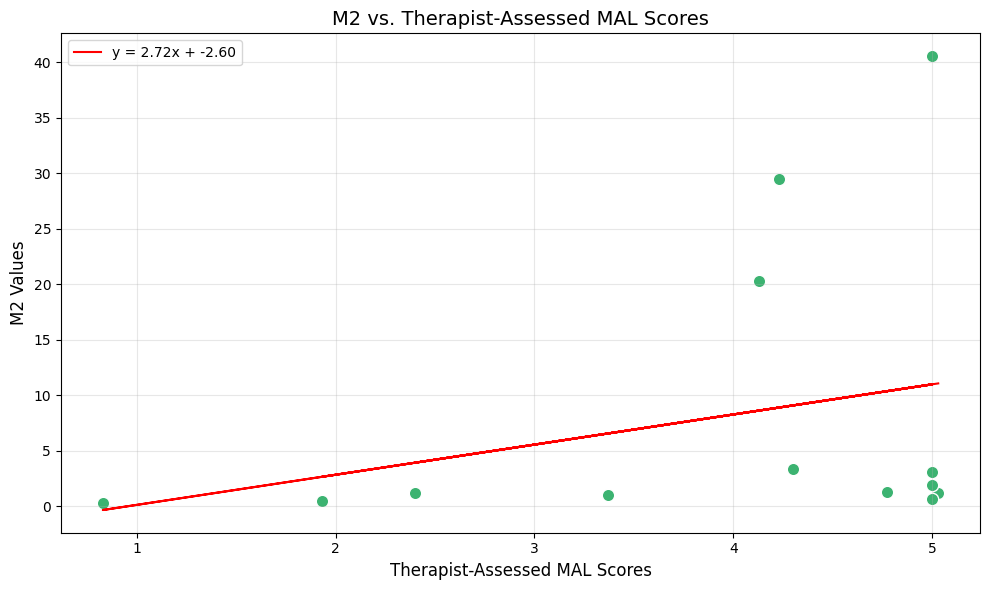

In [15]:
# Load data
patient_df = load_patient_data()

# Process all data (handle missing)
index, M2_affected, mal_score_dict, missing_patients = calculate_m2(patient_df)

# Consistent score order
mal_scores = [mal_score_dict[pid] for pid in index]

# Execute report
generate_quality_report(missing_patients, len(index))

if len(mal_scores) > 0 and len(M2_affected) > 0:
    plot_results(mal_scores, M2_affected)

